# Dataset analysis

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import importlib
import pywt

importlib.reload(util)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'pywt'

Prototyping of the intrusion detection system, based on the BCCC-CIC-IDS-2017 dataset.

In [109]:
# Load the data

filenames = [
    'friday_benign.csv',
    'ddos_loit.csv',
    'portscan.csv'
]

df = util.read_files(filenames)

df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
df = df.set_index('timestamp')
df = df.sort_index()

# Dataset review

In [110]:
df.head()

,flow_id,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,...,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-07-07 07:59:50.315195,192.168.10.50_56108_192.168.10.3_3268_TCP_2017...,192.168.10.50,56108,192.168.10.3,3268,TCP,728.909637,366,239,127,...,5.784995,7.357051,16.430229,1.907349e-06,728.909373,4.425926,2.351852,855.814815,855.814815,Benign
2017-07-07 07:59:50.316273,192.168.10.50_42144_192.168.10.3_389_TCP_2017-...,192.168.10.50,42144,192.168.10.3,389,TCP,696.908053,321,214,107,...,6.574602,7.437127,16.406959,9.536743e-07,696.907800,4.037736,2.018868,800.641509,800.641509,Benign
2017-07-07 08:00:34.845380,192.168.10.9_63210_224.0.0.252_5355_UDP_2017-0...,192.168.10.9,63210,224.0.0.252,5355,UDP,0.100126,22,22,0,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,Benign
2017-07-07 08:00:35.164943,192.168.10.9_137_192.168.10.3_137_UDP_2017-07-...,192.168.10.9,137,192.168.10.3,137,UDP,93.069427,40,20,20,...,4.898379,12.537105,50.763201,2.861023e-06,93.069201,2.500000,2.500000,147.500000,147.500000,Benign
2017-07-07 08:00:35.215632,192.168.10.9_49429_192.168.10.3_53_UDP_2017-07...,192.168.10.9,49429,192.168.10.3,53,UDP,0.000245,4,2,2,...,0.000004,0.000000,0.000004,4.053116e-06,0.000004,0.000000,0.000000,0.000000,0.000000,Benign


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 621158 entries, 2017-07-07 07:59:50.315195 to 2017-07-07 16:02:41.005391
Columns: 121 entries, flow_id to label
dtypes: float64(61), int64(55), object(5)
memory usage: 578.2+ MB


In [112]:
ip_prefix = '192.168'

subnet_in_traffic = df[df['dst_ip'].str.startswith(ip_prefix)].copy()

subnet_in_traffic.head()

,flow_id,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,...,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-07-07 07:59:50.315195,192.168.10.50_56108_192.168.10.3_3268_TCP_2017...,192.168.10.50,56108,192.168.10.3,3268,TCP,728.909637,366,239,127,...,5.784995,7.357051,16.430229,1.907349e-06,728.909373,4.425926,2.351852,855.814815,855.814815,Benign
2017-07-07 07:59:50.316273,192.168.10.50_42144_192.168.10.3_389_TCP_2017-...,192.168.10.50,42144,192.168.10.3,389,TCP,696.908053,321,214,107,...,6.574602,7.437127,16.406959,9.536743e-07,696.907800,4.037736,2.018868,800.641509,800.641509,Benign
2017-07-07 08:00:35.164943,192.168.10.9_137_192.168.10.3_137_UDP_2017-07-...,192.168.10.9,137,192.168.10.3,137,UDP,93.069427,40,20,20,...,4.898379,12.537105,50.763201,2.861023e-06,93.069201,2.500000,2.500000,147.500000,147.500000,Benign
2017-07-07 08:00:35.215632,192.168.10.9_49429_192.168.10.3_53_UDP_2017-07...,192.168.10.9,49429,192.168.10.3,53,UDP,0.000245,4,2,2,...,0.000004,0.000000,0.000004,4.053116e-06,0.000004,0.000000,0.000000,0.000000,0.000000,Benign
2017-07-07 08:00:35.215812,192.168.10.9_65512_192.168.10.3_53_UDP_2017-07...,192.168.10.9,65512,192.168.10.3,53,UDP,0.000225,4,2,2,...,0.000048,0.000000,0.000048,4.792213e-05,0.000048,0.000000,0.000000,0.000000,0.000000,Benign


In [113]:
from numpy import empty

subnet_in_traffic['flows_count'] = 1

subnet_in_traffic = subnet_in_traffic.resample('1s').agg({
    'flows_count': lambda x: x.sum() if not x.empty else 0,
    'down_up_rate': lambda x: x.mean() if not x.empty else 0,
    'packets_count': 'sum',
    'bytes_rate': lambda x: x.mean() if not x.empty else 0,
    'total_payload_bytes': 'sum',
    'rst_flag_counts': 'sum',
    # if contains any != bening then it is not benign
    'label': lambda x: 0 if x.eq('Benign').all() else 1
    # '': 'sum',
    # 'label': 'first'
})

subnet_in_traffic.head()

,flows_count,down_up_rate,packets_count,bytes_rate,total_payload_bytes,rst_flag_counts,label
timestamp,,,,,,,
2017-07-07 07:59:50,2,0.51569,687,96.412162,136954,2,0
2017-07-07 07:59:51,0,0.00000,0,0.000000,0,0,0
2017-07-07 07:59:52,0,0.00000,0,0.000000,0,0,0
2017-07-07 07:59:53,0,0.00000,0,0.000000,0,0,0
2017-07-07 07:59:54,0,0.00000,0,0.000000,0,0,0


# Continous wavelet transform for 1 feature

In [114]:
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(
    subnet_in_traffic['flows_count'],
    scales,
    'morl',
    method = 'fft',
    sampling_period=len(subnet_in_traffic)
)

# pywt.wavelist()

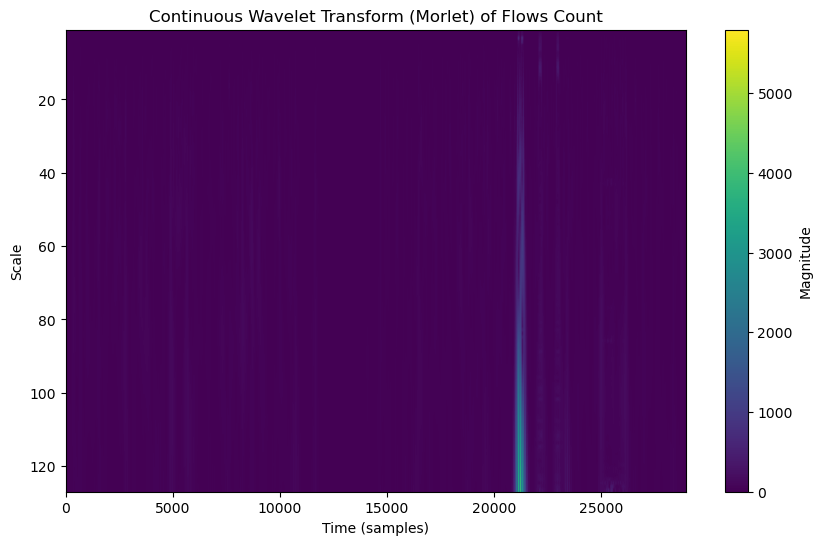

In [115]:
plt.figure(figsize=(10, 6))

plt.imshow(
    np.abs(coefficients),
    extent=[0, len(subnet_in_traffic), scales[-1], scales[0]],
    cmap='viridis',
    aspect='auto'
)

plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform (Morlet) of Flows Count')
plt.xlabel('Time (samples)')
plt.ylabel('Scale')

plt.show()

# Discrete wavelet transform

14486 14486


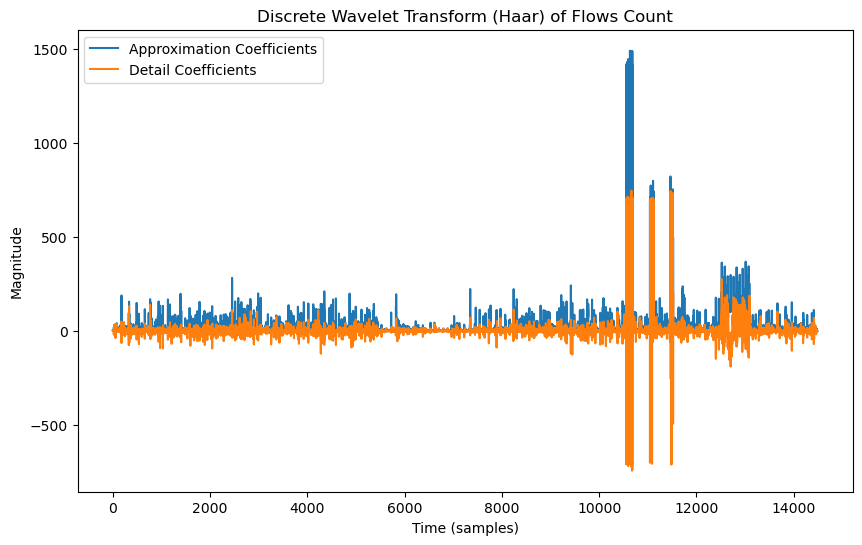

In [116]:
cA, cD = pywt.dwt(subnet_in_traffic['flows_count'], 'haar')

print(len(cA), len(cD))

plt.figure(figsize=(10, 6))

plt.plot(cA, label='Approximation Coefficients')
plt.plot(cD, label='Detail Coefficients')

plt.legend()
plt.title('Discrete Wavelet Transform (Haar) of Flows Count')
plt.xlabel('Time (samples)')
plt.ylabel('Magnitude')

plt.show()

In [117]:
dwt_coefficients = {}

for column in subnet_in_traffic.columns:
    approximate, detail = pywt.dwt(subnet_in_traffic[column], 'haar')

    dwt_coefficients[column + '_approximate'] = approximate
    dwt_coefficients[column + '_detail'] = detail

dwt_df = pd.DataFrame(dwt_coefficients)

In [118]:
dwt_df.head()

,flows_count_approximate,flows_count_detail,down_up_rate_approximate,down_up_rate_detail,packets_count_approximate,packets_count_detail,bytes_rate_approximate,bytes_rate_detail,total_payload_bytes_approximate,total_payload_bytes_detail,rst_flag_counts_approximate,rst_flag_counts_detail,label_approximate,label_detail
0,1.414214,1.414214,0.364648,0.364648,485.782359,485.782359,68.173693,68.173693,96841.102111,96841.102111,1.414214,1.414214,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [119]:
from sklearn.decomposition import PCA

PCA_components = 3

pca = PCA(n_components=PCA_components)

principal_components = pca.fit_transform(dwt_df)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
principal_df.head()

,PC1,PC2,PC3
0,-1.329051e+06,801867.011167,64034.562908
1,-1.329104e+06,801832.840895,-60780.346520
2,-1.329104e+06,801832.840895,-60780.346520
3,-1.329104e+06,801832.840895,-60780.346520
4,-1.329104e+06,801832.840895,-60780.346520


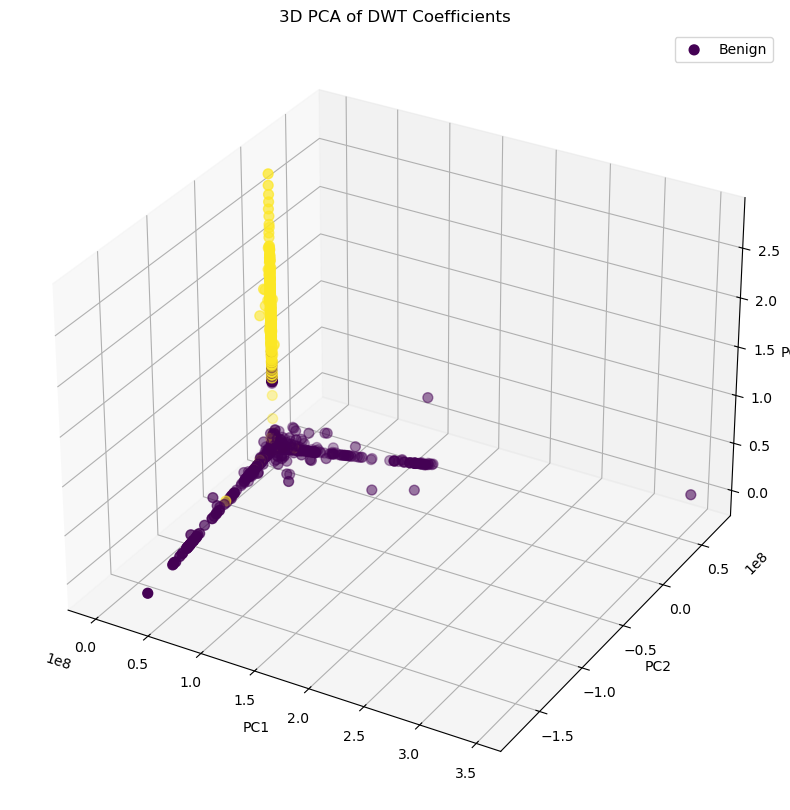

In [120]:
# visualize 3 components

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    principal_df['PC1'],
    principal_df['PC2'],
    principal_df['PC3'],
    c = subnet_in_traffic['label'][::2],
    cmap='viridis',
    s=50
)

plt.title('3D PCA of DWT Coefficients')
plt.legend(['Benign', 'Malicious'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

In [121]:
# Logistic regression just for example

import statsmodels.api as sm

## label assignment needs to be done better
aligned_label = subnet_in_traffic['label'][::2].reset_index(drop=True)

aligned_principal_df = principal_df.reset_index(drop=True)

logit_model = sm.Logit(aligned_label, aligned_principal_df).fit()

# Display the summary
logit_model.summary()


Optimization terminated successfully.
         Current function value: 0.225270
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                14486
Model:                          Logit   Df Residuals:                    14483
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                -0.02646
Time:                        19:20:57   Log-Likelihood:                -3263.3
converged:                       True   LL-Null:                       -3179.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1        -3.225e-07   1.59e-08    -20.338      0.000   -3.54e-07   -2.91e-07
PC2         1.057e-07   2.27e-08      4.651      0.000    6.12e-08     1.5e-07
PC3          5.43e-05   7.93e-07     68.430      0.000    5.27e-05    5.59e-05
==============================================================================
"""

In [122]:
# confusion matrix

X_train, X_test, y_train, y_test = train_test_split(principal_df, subnet_in_traffic['label'][::2], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

predictions = logistic_model.predict(X_test)

print(confusion_matrix(y_test, predictions))

[[2706    7]
 [  62  123]]


In [123]:
# classification summary

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2713
           1       0.95      0.66      0.78       185

    accuracy                           0.98      2898
   macro avg       0.96      0.83      0.88      2898
weighted avg       0.98      0.98      0.97      2898



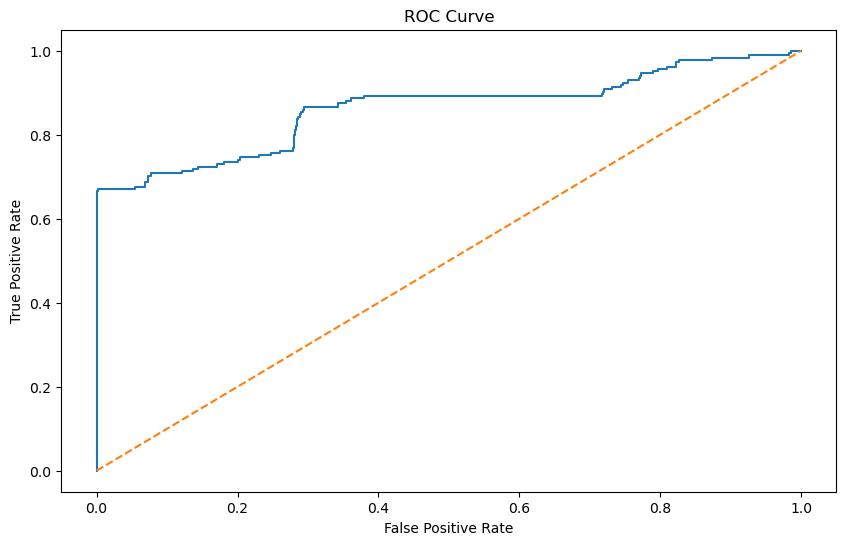

In [124]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [125]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('Optimal Threshold:', optimal_threshold)

Optimal Threshold: 0.05129498036653859


In [126]:
predictions = (y_pred_proba >= optimal_threshold).astype(int)

print(confusion_matrix(y_test, predictions))

# classification summary with optimal threshold

print(classification_report(y_test, predictions))

[[2706    7]
 [  61  124]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2713
           1       0.95      0.67      0.78       185

    accuracy                           0.98      2898
   macro avg       0.96      0.83      0.89      2898
weighted avg       0.98      0.98      0.97      2898

